In [56]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

In [57]:
df_transactions = pd.read_json('../data/transactions.json', lines=True)
df_users = pd.read_csv('../data/users.csv')
df_merchants = pd.read_csv('../data/merchants.csv')

In [58]:
df_merged = pd.merge(df_transactions, df_users, on='user_id', how='left')
df_merged = pd.merge(df_merged, df_merchants, on='merchant_id', how='left')
df_merged = df_merged.rename(columns={'country_x': 'country_user', 'country_y': 'country_merchant'})
df = df_merged

In [59]:
# Extract latitude and longitude into separate columns
df['latitude'] = df['location'].apply(lambda x: x['lat'])
df['longitude'] = df['location'].apply(lambda x: x['long'])
df.drop(columns=['location'], inplace=True)

In [60]:
# --------- Temporal data feature engineering
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek  # 0=Monday

# df['is_weekend'] = df['day_of_week'] >= 5
# df['is_weekend'] = df['is_weekend'].astype(int)

df['timestamp'] = pd.to_datetime(df['timestamp'])
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['days_since_signup'] = (df['timestamp'] - df['signup_date']).dt.total_seconds() / (3600 * 24)
# df['month'] = df['timestamp'].dt.month

In [61]:
# Time Since Last Transaction: User-level
df = df.sort_values(['user_id', 'timestamp'])
df['time_since_last_user_txn'] = (
    df.groupby('user_id')['timestamp']
    .diff()
    .dt.total_seconds()
)

# Time Since Last Transaction: Merchant-level
df = df.sort_values(['merchant_id', 'timestamp'])
df['time_since_last_merchant_txn'] = (
    df.groupby('merchant_id')['timestamp']
    .diff()
    .dt.total_seconds()
)

df['last_user_merchant_ts'] = df.groupby(['user_id', 'merchant_id'])['timestamp'].shift(1)
df['time_since_last_user_merchant'] = (df['timestamp'] - df['last_user_merchant_ts']).dt.total_seconds()

df.drop(columns=['last_user_merchant_ts'], inplace=True)

In [62]:
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c  # distance in km


# --------- Geo-data feature engineering
df.sort_values(by=['user_id', 'timestamp'], inplace=True)

# Shift lat/lon to get last user's lat/lon
df['prev_latitude'] = df.groupby('user_id')['latitude'].shift(1)
df['prev_longitude'] = df.groupby('user_id')['longitude'].shift(1)

df['distance_from_last_txn_km'] = df.apply(
    lambda row: haversine_distance(row['prev_latitude'], row['prev_longitude'],
                                   row['latitude'], row['longitude']),
    axis=1
)

df['velocity_kmph'] = df.apply(
    lambda row: (
        row['distance_from_last_txn_km'] / (row['time_since_last_user_txn'] / 3600)
        if row['time_since_last_user_txn'] > 0 else np.nan
    ),
    axis=1
)

In [63]:
df['date'] = pd.to_datetime(df['timestamp']).dt.date
tmp = df.groupby(['date', 'user_id'])['device'].nunique().reset_index()
tmp.rename(columns={'device': 'number_unique_devices_last_day'}, inplace=True)
df = df.merge(tmp, on=['date', 'user_id'], how='left')
df = df.drop(columns=["date"])

In [64]:
df['year_month'] = df['timestamp'].dt.strftime('%Y-%m')

tmp = df.groupby(['year_month', 'user_id'])['device'].nunique().reset_index()
tmp.rename(columns={'device': 'number_unique_devices_per_month'}, inplace=True)

df = df.merge(tmp, on=['year_month', 'user_id'], how='left')
df = df.drop(columns=["year_month"])

In [65]:
df['year'] = df['timestamp'].dt.year

tmp = df.groupby(['year', 'user_id'])['device'].nunique().reset_index()
tmp.rename(columns={'device': 'number_unique_devices_per_year'}, inplace=True)

df = df.merge(tmp, on=['year', 'user_id'], how='left')
df = df.drop(columns=["year"])

In [66]:
df["expenses_to_isntallment_ratio"] = df["sum_of_monthly_expenses"] / df["sum_of_monthly_installments"]

In [67]:
df['date'] = pd.to_datetime(df['timestamp']).dt.date

tmp = df.groupby(['date', 'user_id'])['amount'].mean().reset_index()
tmp.rename(columns={'amount': 'avg_daily_amount'}, inplace=True)

df = df.merge(tmp, on=['date', 'user_id'], how='left')
df = df.drop(columns=["date"])

In [68]:
df["percent_change_from_avg_daily_transaction_amount"] = (df["amount"]-df["avg_daily_amount"])/df["avg_daily_amount"]
df["percent_diff_trans_amt_vs_merch_avg_amt"] = (df["amount"]-df["avg_transaction_amount"])/df["avg_transaction_amount"]

In [69]:
# import pandas as pd
# from scipy.stats import zscore
# from datetime import timedelta

# df_tmp = df
# df_tmp['timestamp'] = pd.to_datetime(df_tmp['timestamp'])
# transactions_df = df_tmp.sort_values('timestamp')

# frauds = transactions_df[transactions_df['is_fraud'] == 1]
# frauds.set_index('timestamp', inplace=True)

# # rolling window 28 days
# rolling_data = frauds['amount'].rolling('1D').agg(['sum', 'count'])

# z_scores = []

# transactions_df = transactions_df.sort_values('timestamp')
# for idx, row in transactions_df.iterrows():
#     current_time = row['timestamp']
#     current_amount = row['amount']
    
#     frauds_last_28d = rolling_data[(rolling_data.index < current_time) & (rolling_data.index >= current_time - timedelta(days=1))]
    
#     # count z-score for 5 frauds per window
#     if len(frauds_last_28d) >= 5:
#         fraud_amounts = frauds_last_28d['sum'].tolist() + [current_amount]
#         z = zscore(fraud_amounts)[-1]
#     else:
#         z = 0  # Za mało danych
    
#     z_scores.append(z)

# transactions_df['z_score_vs_fraud_1d'] = z_scores
# df = transactions_df

In [70]:
# cols_to_drop = ['transaction_id','user_id','timestamp','merchant_id','signup_date', 'currency']
# df = df.drop(columns=cols_to_drop)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 48 columns):
 #   Column                                            Non-Null Count   Dtype         
---  ------                                            --------------   -----         
 0   transaction_id                                    500000 non-null  object        
 1   timestamp                                         500000 non-null  datetime64[ns]
 2   user_id                                           500000 non-null  object        
 3   merchant_id                                       500000 non-null  object        
 4   amount                                            500000 non-null  float64       
 5   channel                                           500000 non-null  object        
 6   currency                                          500000 non-null  object        
 7   device                                            500000 non-null  object        
 8   payment_method

In [75]:
categorical_cols = [
    'channel', 'device', 'payment_method',
    'sex', 'education', 'primary_source_of_income',
    'country_user', 'category', 'country_merchant' 
]

binary_cols = [
    'is_international', 'is_first_time_merchant', 'has_fraud_history'
]

In [77]:
# Process categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Process binary variables
for col in binary_cols:
    df[col] = df[col].astype(int)

# Normalize numerical features
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [78]:
df = df.drop(columns=['number_unique_devices_per_month', 'number_unique_devices_per_year',
'avg_daily_amount', 'percent_diff_trans_amt_vs_merch_avg_amt',
'percent_change_from_avg_daily_transaction_amount',
'prev_latitude', 'prev_longitude'
])


In [81]:
numerical_cols = [col for col in df.columns if col not in categorical_cols]
numerical_cols = [col for col in numerical_cols if col not in binary_cols]
numerical_cols = [col for col in numerical_cols if col!="is_fraud"]
numerical_cols = [col for col in numerical_cols if col not in ['transaction_id','user_id','timestamp','merchant_id','signup_date', 'currency']]
numerical_cols

['amount',
 'session_length_seconds',
 'age',
 'sum_of_monthly_installments',
 'sum_of_monthly_expenses',
 'risk_score',
 'trust_score',
 'number_of_alerts_last_6_months',
 'avg_transaction_amount',
 'account_age_months',
 'latitude',
 'longitude',
 'hour',
 'day_of_week',
 'days_since_signup',
 'time_since_last_user_txn',
 'time_since_last_merchant_txn',
 'time_since_last_user_merchant',
 'distance_from_last_txn_km',
 'velocity_kmph',
 'number_unique_devices_last_day',
 'expenses_to_isntallment_ratio']

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 41 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   transaction_id                  500000 non-null  object        
 1   timestamp                       500000 non-null  datetime64[ns]
 2   user_id                         500000 non-null  object        
 3   merchant_id                     500000 non-null  object        
 4   amount                          500000 non-null  float64       
 5   channel                         500000 non-null  int64         
 6   currency                        500000 non-null  object        
 7   device                          500000 non-null  int64         
 8   payment_method                  500000 non-null  int64         
 9   is_international                500000 non-null  int64         
 10  session_length_seconds          500000 non-null  float64

In [83]:
#Create Time-Based Sequences
target_column = 'is_fraud'
user_column = 'user_id'
time_window_hours = 24  # Look back window of 24 hours
sequence_length = 10    # Max transactions to consider per window
padding_value = 0  

data_sequences = []
labels = []
sequence_indices = []  # To track which rows correspond to which sequences

# Group by user
grouped = df.groupby(user_column)

for user_id, user_data in grouped:
    # Sort by timestamp
    user_data = user_data.sort_values(by='timestamp')
    
    # Convert to numpy arrays
    user_data_values = user_data[numerical_cols].values
    timestamps = user_data['timestamp'].values
    
    # Convert timestamps to numpy datetime64
    if not np.issubdtype(timestamps.dtype, np.datetime64):
        timestamps = np.array([np.datetime64(ts) for ts in timestamps])
    
    for i in range(len(user_data)):
        current_time = timestamps[i]
        time_threshold = current_time - np.timedelta64(time_window_hours, 'h')
        
        # Get indices of transactions within last 24 hours
        mask = (timestamps >= time_threshold) & (timestamps <= current_time)
        window_indices = np.where(mask)[0]
        
        # Get transactions within window
        window_data = user_data_values[window_indices]
        
        if len(window_data) > 0:
            # Pad if fewer than sequence_length transactions
            if len(window_data) < sequence_length:
                pad_length = sequence_length - len(window_data)
                padding = np.full((pad_length, len(numerical_cols)), padding_value)
                window_data = np.vstack([padding, window_data])
            
            # Take most recent sequence_length transactions
            window_data = window_data[-sequence_length:]
            
            data_sequences.append(window_data)
            labels.append(user_data[target_column].iloc[i])
            sequence_indices.append(user_data.index[i])  # Store the original index

# Convert to numpy arrays
data_sequences = np.array(data_sequences)
labels = np.array(labels)

In [84]:
# Create DataFrame index to position mapping
index_to_pos = {idx: pos for pos, idx in enumerate(df.index)}

# Get the positions of the last transaction in each sequence
seq_positions = [index_to_pos[idx] for idx in sequence_indices]

# Split into train and test sets (80-20 split)
(X_seq_train, X_seq_test, 
 seq_pos_train, seq_pos_test,
 y_train, y_test) = train_test_split(
    data_sequences,
    seq_positions,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# Prepare input dictionaries
def create_input_dict(sequences, positions, df):
    inputs = {'numerical_seq': sequences}
    
    # Add categorical inputs
    for col in categorical_cols:
        inputs[f'{col}_input'] = df.iloc[positions][col].values.reshape(-1, 1)
    
    # Add binary features
    inputs['binary_features'] = df.iloc[positions][binary_cols].values
    
    return inputs

train_data = create_input_dict(X_seq_train, seq_pos_train, df)
test_data = create_input_dict(X_seq_test, seq_pos_test, df)

In [85]:
# Analyze categorical feature cardinalities
categorical_cardinalities = {col: df[col].nunique() for col in categorical_cols}
embedding_dims = {
    col: min(50, max(2, card // 2 + 1)) 
    for col, card in categorical_cardinalities.items()
}

In [86]:
def create_deep_rnn_model(sequence_length, numerical_cols, categorical_cols, binary_cols, 
                         categorical_cardinalities, embedding_dims):
    # Numerical sequence input (Deep LSTM path)
    numerical_input = Input(shape=(sequence_length, len(numerical_cols)), name='numerical_seq')
    
    # Deep LSTM layers (3 layers)
    lstm_layer1 = LSTM(128, return_sequences=True, name='LSTM_1')(numerical_input)
    lstm_layer1 = Dropout(0.2)(lstm_layer1)
    
    lstm_layer2 = LSTM(128, return_sequences=True, name='LSTM_2')(lstm_layer1)
    lstm_layer2 = Dropout(0.2)(lstm_layer2)
    
    lstm_layer3 = LSTM(128, name='LSTM_3')(lstm_layer2)
    lstm_layer3 = Dropout(0.2)(lstm_layer3)
    
    # Entity embeddings for categorical features
    categorical_inputs = []
    categorical_embeddings = []
    
    for col in categorical_cols:
        input_layer = Input(shape=(1,), name=f'{col}_input')
        categorical_inputs.append(input_layer)
        
        embedding = Embedding(
            input_dim=categorical_cardinalities[col] + 1,
            output_dim=embedding_dims[col],
            name=f'{col}_embedding',
            embeddings_regularizer=l2(1e-4)
        )(input_layer)
        
        flattened = Flatten()(embedding)
        flattened = Dropout(0.1)(flattened)
        categorical_embeddings.append(flattened)
    
    # Binary features input
    binary_input = Input(shape=(len(binary_cols),), name='binary_features')
    
    # Combine all features
    combined = Concatenate()([lstm_layer3] + categorical_embeddings + [binary_input])
    
    # Feedforward 
    x = Dense(256, activation='relu')(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Output layer
    output = Dense(1, activation='sigmoid')(x)
    
    # Create model
    model = Model(
        inputs=[numerical_input] + categorical_inputs + [binary_input],
        outputs=output
    )
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

In [87]:
train_data.keys()

dict_keys(['numerical_seq', 'channel_input', 'device_input', 'payment_method_input', 'sex_input', 'education_input', 'primary_source_of_income_input', 'country_user_input', 'category_input', 'country_merchant_input', 'binary_features'])

In [89]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

# Create the model with correct input names
model = create_deep_rnn_model(
    sequence_length=sequence_length,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    binary_cols=binary_cols,
    categorical_cardinalities=categorical_cardinalities,
    embedding_dims=embedding_dims
)

# First, flatten the sequences for resampling
n_samples_train = X_seq_train.shape[0]
X_seq_train_flat = X_seq_train.reshape(n_samples_train, -1)

# Combine all features for resampling
all_features_train = np.hstack([
    X_seq_train_flat,
    np.concatenate([train_data[f'{col}_input'] for col in categorical_cols], axis=1),
    train_data['binary_features']
])

# # Define resampling pipeline
# resampling = Pipeline([
#     ('under', RandomUnderSampler(sampling_strategy=0.33, random_state=42)),  # Reduce majority to 2x minority
#     ('over', SMOTE(sampling_strategy=1, random_state=42))  # Then oversample minority to balance
# ])
resampling = Pipeline([
    ('under', RandomUnderSampler(sampling_strategy=0.5, random_state=42))  # Reduce majority to 2x minority
])

# Perform resampling
X_resampled, y_resampled = resampling.fit_resample(all_features_train, y_train)

# Split back into original feature structure
seq_length = sequence_length * len(numerical_cols)
X_seq_resampled = X_resampled[:, :seq_length].reshape(-1, sequence_length, len(numerical_cols))

# Calculate where categorical features start
cat_start = seq_length
cat_features = []
for col in categorical_cols:
    cat_end = cat_start + 1
    cat_features.append(X_resampled[:, cat_start:cat_end])
    cat_start = cat_end

binary_resampled = X_resampled[:, cat_start:]

# Rebuild the train_data dictionary
resampled_train_data = {
    'numerical_seq': X_seq_resampled
}

for i, col in enumerate(categorical_cols):
    resampled_train_data[f'{col}_input'] = cat_features[i]

resampled_train_data['binary_features'] = binary_resampled

# Now train the model without class weights
history = model.fit(
    resampled_train_data,
    y_resampled,
    batch_size=64,
    epochs=50,
    validation_data=(test_data, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_auc',
            mode='max',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_auc',
            mode='max',
            factor=0.1,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.keras',
            monitor='val_auc',
            mode='max',
            save_best_only=True,
            verbose=1
        )
    ],
    verbose=1
)

c:\Users\laura\Documents\GitHub\HackathonSGH\hackaton-sgh\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\laura\Documents\GitHub\HackathonSGH\hackaton-sgh\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\laura\Documents\GitHub\HackathonSGH\hackaton-sgh\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Epoch 1/50
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6603 - auc: 0.5000 - loss: 0.6451
Epoch 1: val_auc improved from -inf to 0.50000, saving model to best_model.keras
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 96s 55ms/step - accuracy: 0.6603 - auc: 0.5000 - loss: 0.6451 - val_accuracy: 0.9152 - val_auc: 0.5000 - val_loss: 0.4652 - learning_rate: 0.0010
Epoch 2/50
1590/1591 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6674 - auc: 0.4969 - loss: 0.6372
Epoch 2: val_auc did not improve from 0.50000
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 91s 57ms/step - accuracy: 0.6674 - auc: 0.4969 - loss: 0.6372 - val_accuracy: 0.9152 - val_auc: 0.5000 - val_loss: 0.4762 - learning_rate: 0.0010
Epoch 3/50
1590/1591 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6669 - auc: 0.5005 - loss: 0.6380
Epoch 3: val_auc did not improve from 0.50000
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 81s 51ms/step - accuracy: 0.6669 - auc: 0.5005 - loss: 0.6380 - val_accuracy: 0.9152 - val_auc: 0.5000 - val_loss: 0.4539 - learning_

In [90]:
### Model with class weights
# # Create the model with correct input names
# model = create_deep_rnn_model(
#     sequence_length=sequence_length,
#     numerical_cols=numerical_cols,
#     categorical_cols=categorical_cols,
#     binary_cols=binary_cols,
#     categorical_cardinalities=categorical_cardinalities,
#     embedding_dims=embedding_dims
# )

# # Compute class weights
# class_weights = compute_class_weight(
#     'balanced',
#     classes=np.unique(y_train),
#     y=y_train
# )
# class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# # Train the model
# history = model.fit(
#     train_data,
#     y_train,
#     batch_size=64,
#     epochs=10,
#     validation_data=(test_data, y_test),
#     class_weight=class_weight_dict,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(
#             monitor='val_auc',
#             mode='max',
#             patience=10,
#             restore_best_weights=True,
#             verbose=1
#         ),
#         tf.keras.callbacks.ReduceLROnPlateau(
#             monitor='val_auc',
#             mode='max',
#             factor=0.1,
#             patience=5,
#             min_lr=1e-6,
#             verbose=1
#         ),
#         tf.keras.callbacks.ModelCheckpoint(
#             'best_model.h5',
#             monitor='val_auc',
#             mode='max',
#             save_best_only=True,
#             verbose=1
#         )
#     ],
#     verbose=1
# )

In [91]:
test_results = model.evaluate(test_data, y_test)
print("\nTest Set Evaluation:")
print(f"Loss: {test_results[0]:.4f}")
print(f"Accuracy: {test_results[1]:.4f}")
print(f"AUC: {test_results[2]:.4f}")


y_pred = model.predict(test_data)
y_pred_classes = (y_pred > 0.5).astype(int)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step - accuracy: 0.9163 - auc: 0.5000 - loss: 0.4644

Test Set Evaluation:
Loss: 0.4652
Accuracy: 0.9152
AUC: 0.5000
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     91518
           1       0.00      0.00      0.00      8482

    accuracy                           0.92    100000
   macro avg       0.46      0.50      0.48    100000
weighted avg       0.84      0.92      0.87    100000


Confusion Matrix:
[[91518     0]
 [ 8482     0]]


c:\Users\laura\Documents\GitHub\HackathonSGH\hackaton-sgh\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\laura\Documents\GitHub\HackathonSGH\hackaton-sgh\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\laura\Documents\GitHub\HackathonSGH\hackaton-sgh\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [ ]:
len(df)

500000

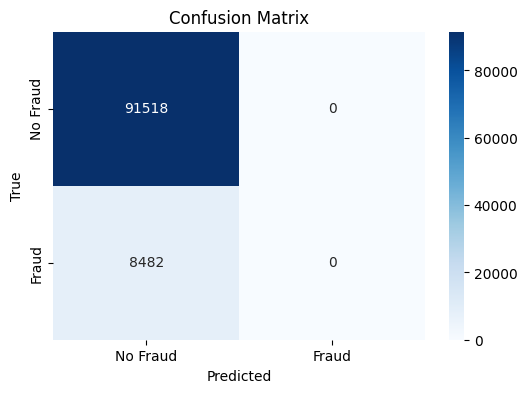

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

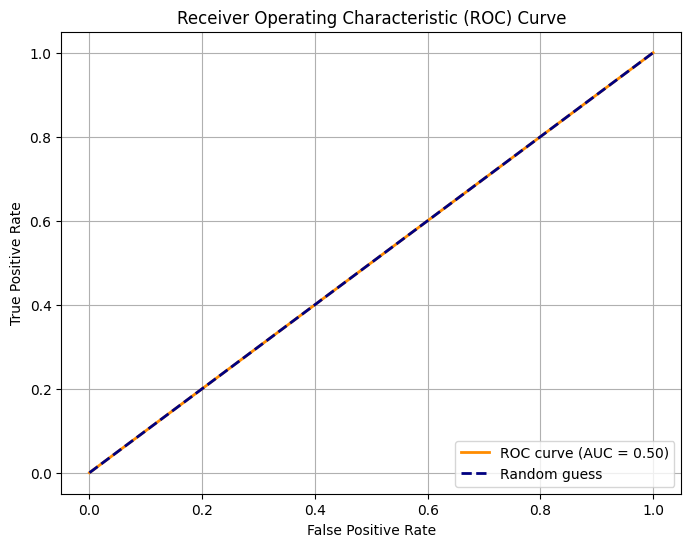

AUC: 0.5


In [93]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_classes)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

auc = roc_auc_score(y_test, y_pred_classes)
print(f'AUC: {auc}')